In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../data/SAMPLE_SUBMISSION.CSV
../data/starcraft-2-player-prediction-challenge-2019.zip
../data/submission.csv
../data/TEST.CSV
../data/TEST_LONG.CSV
../data/TRAIN.CSV
../data/TRAIN_LONG.CSV


Important definitions

In [2]:
#To be sure that we get all the right keys
CSV_KEYS = ['id', 'class', 's', 'sBase', 'sMineral']
for i in range(10):
    CSV_KEYS.append('hotkey' + str(i))

#Define map class->value
CLASSES = {}

#Zerg -> 0
#Protoss -> 1
#Terran -> 2
CLASSES['Zerg'] = 0
CLASSES['Protoss'] = 1
CLASSES['Terran'] = 2

Functions to get clean data

In [3]:
import csv
from collections import defaultdict

def get_train_data(csv_file='../data/TRAIN.CSV'):
    
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        ids = []

        for row in cvs_reader:

            csv_dict = defaultdict(int)
            csv_dict['id'] = row[0]
            ids.append(row[0])
            csv_dict['class'] = CLASSES[row[1]]
            t = 0
            for i in range(1, len(row)-2):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    csv_dict[row[len(row)-i][:-1]] += 1/t
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            data.append(csv_dict)
        return (data, ids)

def get_test_data(csv_file="../data/TEST.CSV"):
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []

        for row in cvs_reader:

            csv_dict = defaultdict(int)
            csv_dict['class'] = CLASSES[row[0]]
            t = 0
            for i in range(1, len(row)-1):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    csv_dict[row[len(row)-i][:-1]] += 1/t
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            data.append(csv_dict)
        return data

In [4]:
data, ids = get_train_data()
print(len(data))
print(ids)

3052
['http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/', 'http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/', 'http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/', 'http://eu.battle.net/sc2/en/profile/4234852/1/First/', 'http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/', 'http://eu.battle.net/sc2/en/profile/3401218/1/Welmu/', 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/', 'http://eu.battle.net/sc2/en/profile/3401218/1/Welmu/', 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/', 'http://eu.battle.net/sc2/en/profile/3401218/1/Welmu/', 'http://eu.battle.net/sc2/en/profile/2896854/1/MǂForGG/', 'http://eu.battle.net/sc2/en/profile/3538115/1/Golden/', 'http://eu.battle.net/sc2/en/profile/250458/1/VortiX/', 'http://eu.battle.net/sc2/en/profile/3538115/1/Golden/', 'http://eu.battle.net/

In [5]:
#Only for visualization purposes
df = pd.DataFrame(data, columns=CSV_KEYS) 
df.head().fillna(0)

,id,class,s,sBase,sMineral,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9
0,http://eu.battle.net/sc2/en/profile/4234852/1/...,1,0.0,0.0,0.0,0.027795,0.249547,0.134139,0.242900,0.157100,0.071299,0.012689,0.000604,0.000000,0.002417
1,http://eu.battle.net/sc2/en/profile/3074362/1/...,1,0.0,0.0,0.0,0.051360,0.311178,0.138973,0.210876,0.187915,0.000000,0.000000,0.000000,0.010272,0.011480
2,http://eu.battle.net/sc2/en/profile/4234852/1/...,1,0.0,0.0,0.0,0.020792,0.145545,0.133663,0.317822,0.135644,0.090099,0.011881,0.000000,0.000000,0.003960
3,http://eu.battle.net/sc2/en/profile/3074362/1/...,1,0.0,0.0,0.0,0.039801,0.289552,0.083582,0.249751,0.284577,0.000000,0.000000,0.000000,0.000000,0.014925
4,http://eu.battle.net/sc2/en/profile/4234852/1/...,1,0.0,0.0,0.0,0.001852,0.114815,0.081481,0.372222,0.159259,0.027778,0.000000,0.000000,0.000000,0.000000


# Stratify Sampling

Cleaning data

In [7]:
#Separate Labels from features
features = []

for sample in data:
    dict_temp = {}
    #New dictionary without the label
    for key, value in sample.items():
        if key != 'id':
            dict_temp[key] = value
    #Append to features list
    features.append(dict_temp)
print(features[0], features[19])
print(len(ids))
print(type(ids))
    

{'class': 1, 'hotkey6': 0.012688821752265853, 'hotkey5': 0.07129909365558913, 'hotkey4': 0.15709969788519723, 'hotkey3': 0.24290030211480534, 'hotkey1': 0.24954682779456372, 'hotkey2': 0.1341389728096683, 'hotkey0': 0.027794561933534714, 'hotkey9': 0.002416918429003021, 'hotkey7': 0.0006042296072507553} {'class': 0, 'hotkey1': 0.3880341880341868, 'hotkey4': 0.4401709401709388, 'hotkey2': 0.17264957264957217, 'hotkey5': 0.01367521367521368, 'hotkey3': 0.03247863247863249}
3052
<class 'list'>


Split

In [8]:
from sklearn.model_selection import train_test_split

df_X = pd.DataFrame(features, columns=CSV_KEYS) 
X = df_X.fillna(0).values
y = np.asarray(ids)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=ids)

*Test if we have correct distribution*

In [9]:
counter = 0

for i in y_valid:
    if i not in y_train:
        counter += 1

print(counter)

0


# KNN

Following the tutorial at: https://towardsdatascience.com/knn-using-scikit-learn-c6bed765be75

In [12]:
#Import the KNeighborsCLassifier class from sklearn
from sklearn.neighbors import KNeighborsClassifier

#Import metrics model to check the accuracy
from sklearn import metrics
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1, 26)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    scores[k] = metrics.accuracy_score(y_valid, y_pred)
    scores_list.append(scores[k])

#Visualize K vs Accuracy

Text(0, 0.5, 'Validation Accuracy')

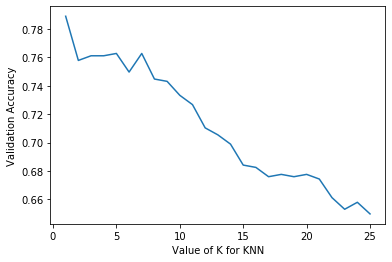

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

#Plot relationship between K and accuracy
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Validation Accuracy')

**Final model with k=3**

In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [15]:
#Open TEST file and prepare TEST data
test_file = '../data/TEST.CSV'
test_data = get_test_data(csv_file=test_file)
print(test_data[0])

defaultdict(<class 'int'>, {'class': 0, 'hotkey6': 1.1234285714285597, 'hotkey1': 0.4400000000000036, 'hotkey0': 0.9817142857142777, 'hotkey2': 0.08799999999999987, 'hotkey9': 0.03999999999999999, 'hotkey7': 0.053714285714285666, 'hotkey3': 0.005714285714285715})


In [16]:
#Testing
df_testX = pd.DataFrame(test_data, columns=CSV_KEYS) 
X_test = df_testX.fillna(0).values

y_predict = knn.predict(X_test)

In [17]:
#Save predictions
predictions_formatted = []

for i, value in enumerate(y_predict, 1):
    predictions_formatted.append([i, value])

df_predict = pd.DataFrame(predictions_formatted)
df_predict.head()

import os
#Remove if exists
submission_path = '../data/submission.csv'
if os.path.exists(submission_path):
    os.remove(submission_path)
df_predict.to_csv(submission_path, header=['RowId','prediction'], mode='w', index=False)